#  <span style="text-decoration:underline;">Assignment 2</span>: Clustering Yelp Data

## Introduction 

In this assignment, we will be working with the [Yelp data set](http://cs-people.bu.edu/bahargam/506/yelp_dataset_challenge_academic_dataset.tar). You can find information about the format of the data set [here](https://www.yelp.com/dataset_challenge).

## Submission 

Please use the following invitation link to create your assignment repository for this assignment: [https://classroom.github.com/a/nowbCi7s](https://classroom.github.com/a/nowbCi7s). Include your BU username within your submission by adding it here: **<asadeg02&gt;**.

Do not delete the output of your code cells. This assignment must be completed **individually** by each student.

## <span style="text-decoration:underline;">Problem 1</span>: Clustering, Scaling, and Visualizing

**<span style="text-decoration:underline;">Part A</span> (35 points):** From the Business Objects data set (`yelp_academic_dataset_business.json`), we want to find culinary districts in Las Vegas. These districts are characterized by the physical proximity and similarity of restaurants. We can use `longitude` and `latitude` to cluster for proximity, and `categories` to cluster for similarity. Only a subset (the top 15) of the most popular categories should be used.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using $k$-means++ (you are permitted to use the implementation available in scikit-learn). Explain your data representation and how you determined the number of clusters in $k$-means++.

**<span style="text-decoration:underline;">Part B</span> (15 points):** Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned.

Note that some categories are inherently more common (e.g., "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

['Fast Food', 'Nightlife', 'Fast Food', 'Chinese', 'Pizza', 'Fast Food', 'Mexican']
[5 2 4 ... 1 0 2]


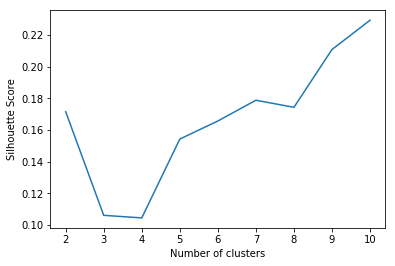

In [1]:
#------------------------------README-----------------------------------------
#For this part the data that is passed to kmeans algorithm 
#has 17 dimensions, 15 for categories and 2 for latitude and longitude
#the first 15 dimensions are for top 15 categories and last 2
#dimensions are for latitude and longitude.

#Values for latitude and longitude have been scaled using min max scaler
#Values for categorical dimensions have been normilized using tf-idf
#doing that the clustering was always biased towards the categories.
#and using tf-idf the max Euclidean norm for categorical vectors is always 1
#so one of the reasonable ways to scale was to multiply latitude and 
#longitude by a constant,by a constant value. the value of this constant 
#has been determined by experiments.
#------------------------------------------------------------------------
import json
import pandas as pd
import sklearn.datasets as sk_data
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import sklearn.manifold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
%matplotlib inline

file_name = 'yelp_academic_dataset_business.json'
min_max_scaler = preprocessing.MinMaxScaler()

def sc_evaluate_clusters(X,max_clusters):
    """ function for ploting the errors 
    for cluster numbers to decide on the number of clusters 
    """
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='euclidean')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    
def create_data_frame_from_json(file_name):
    """ this function reads the bussiness_academic file and creates  
    a data frame from that.this data frame only contains data 
    for resturants in Las Vegas
    """
    data = []
    row_index = 0;
    with open(file_name) as f:
        for line in f:
            row = json.loads(line)
            #append only resturants in Las Vegas
            if row['city'] == 'Las Vegas' and 'Restaurants' in str(row['categories']):
                data.append(json.loads(line))
            row_index += 1
    return  pd.DataFrame(data)

def get_max_length_category_vector(category_vactors):
    """ this function reads the bussiness_academic file and creates  
    a data frame from that.this data frame only contains data 
    for resturants in Las Vegas
    """
    max_length = 0
    for category_vector in category_vactors:
        if np.linalg.norm(np.array(category_vector)) > max_length:
            max_length = np.linalg.norm(np.array(category_vector))
            
    return max_length
    
def create_dictionary_for_category_count(categories):
    """ This function gets categories column of the 
    original the frame as a list as the input and returns a dictionary
    with categorie tokens as the keys and their frequency in the data set
    as the value and returns this dictionary
    """
    #dictionary for count of each category 
    categoriesCountDict = {}
    for category in categories:
        for word in category:
            #removing leading spaces 
            word = word.strip()
            #ignoring Resturants label since we have already taken them into account
            if (word != 'Restaurants'):
                if word in categoriesCountDict:
                    #word already exits in the dictonary as a key
                    categoriesCountDict[word] += 1 
                else:
                    #first time seeing the word
                    categoriesCountDict[word] = 1
    return categoriesCountDict 

def get_top_15_category_list(categoriesCountDict):
    """this function returns the list of top 15 
    categories and it takes a dictionary having categories as the key 
    and their coressponding frequency as the value, as the input
    """
    categoriesCountDict = sorted(categoriesCountDict, key=categoriesCountDict.get, reverse=True)
    return categoriesCountDict[:15]
    
def get_list_of_category_lists_for_each_row(df,top_15_categories):
    """this function takes top_15_categories and the original data frame 
    as the input and creates a list of all the category lists in 
    data frame enteries. It removes all the categoris that are not in 
    top_15_categories from category list of each row.
    the purpose is to pass the list returned from this function to tf-idf
    """
    categoriesList = []
    for index, row in df.iterrows():
        categories = []
        for category in top_15_categories:
            if category in row['categories']:
                categories.append(category)
        categoriesList.append(categories)
    return categoriesList 

def normalize_category_vectors_using_tfidf(categoriesList):
    """this function takes categories list of all the rows 
    and normilize and adjusts their importance and creates 
    category vectors for each data entry using tfidf.
    it returns list of those category vectors
    """
    vectorizer = TfidfVectorizer(tokenizer=lambda x : x, lowercase=False)
    categoryVectors =  vectorizer.fit_transform(categoriesList)
    categoryVectors = categoryVectors.todense().tolist()
    return categoryVectors

def get_real_category_label_for_clusters(vectorizer, centroids):
    category_labe_for_centroids = []
    for cluster_center in centroids:
        feature_with_max_value = 0
        max_value_index = 0
        for i in range (0, 15):
            if cluster_center[i] > feature_with_max_value:
                feature_with_max_value = cluster_center[i]
                max_value_index = i
        #it's important to get the freature names from vectorizer since order of 
        #categories might not be the same as order of top_15
        #print(vectorizer.get_feature_names())
        category_labe_for_centroids.append(vectorizer.get_feature_names()[max_value_index])
    return category_labe_for_centroids
     
    
df = create_data_frame_from_json(file_name)    
df['latitude'] = min_max_scaler.fit_transform(df['latitude'].values.reshape(-1,1))
df['longitude'] = min_max_scaler.fit_transform(df['longitude'].values.reshape(-1,1))
latitudeList = df['latitude'].tolist()
longitudeList = df['longitude'].tolist()


categoriesCountDict = create_dictionary_for_category_count(df["categories"].tolist())
top_15_categories = get_top_15_category_list(categoriesCountDict)
categoriesList = get_list_of_category_lists_for_each_row(df,top_15_categories)
vectorizer = TfidfVectorizer(tokenizer=lambda x : x, lowercase=False)
categoryVectors =  vectorizer.fit_transform(categoriesList)
categoryVectors = categoryVectors.todense().tolist()

for i in range(0,len(categoryVectors)):
    latitude = 2.8 *latitudeList[i]
    longitude = 2.8 *longitudeList[i]
    categoryVectors[i].append(latitude)
    categoryVectors[i].append(longitude)

sc_evaluate_clusters(categoryVectors,10)    
kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit_predict(categoryVectors)

#centoids
centroids = kmeans.cluster_centers_
#labels
labels = kmeans.labels_
category_labe_for_centroids = []
for cluster_center in centroids:
    feature_with_max_value = 0
    max_value_index = 0
    for i in range (0, 15):
        if cluster_center[i] > feature_with_max_value:
            feature_with_max_value = cluster_center[i]
            max_value_index = i
    category_labe_for_centroids.append(vectorizer.get_feature_names()[max_value_index]) 
print(category_labe_for_centroids)  
#-----------------------------README---------------------------------
#Based on the plot, looking for the local 
#maximum the reasonable number of clusters is 7!!!
#---------------------------------------------------------------------



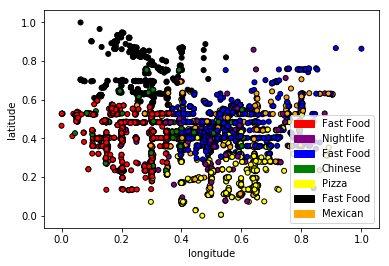

In [2]:
import matplotlib.patches as mpatches
import matplotlib

colors =['red','purple', 'blue', 'green','yellow','black', 'orange']

def create_patches(colors, real_labels):
    """this function takes a list of colors and a list 
    of real names as the input. length of these two lists 
    must be the same.it create corresponding patches for plot legend
    """
    patches = []
    for i in range (0, len(real_labels)):
        patch = mpatches.Patch(color=colors[i], label= real_labels[i])
        patches.append(patch)
    return patches

plt.scatter(longitudeList, latitudeList, marker='o', c=labels, s=25, edgecolor='k', cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.legend(handles=create_patches(colors, category_labe_for_centroids))   

## <span style="text-decoration:underline;">Problem 2</span>: Outliers and Unsupervised Clustering

**<span style="text-decoration:underline;">Part A</span> (15 points):** Detect the top five outliers for each cluster that you generated in Problem 1. These are the restaurants that are the farthest from the centroids of their clusters.

In [3]:
import pprint

def get_top_five_outlier(clustNum, labels, real_data, centroids):
    """this function returns indices of top five outliers for one cluster with 
    number clustNum clustNum is the number of cluster whose top 5 outliers 
    we want to compute lebels are the labels list of kmeans
    real_data is the list of all vectors
    centroids is the list of centroids for clusters
    """
    distances = {}
    centroid = centroids[clustNum]
    for i in range (0, len(labels)):
        if labels[i] == clustNum:
            distance = np.linalg.norm(np.array(centroid)-np.array(real_data[i]))
            distances[i] = distance
    distances = sorted(distances, key=distances.get, reverse=True)
    return distances[:5]

def get_bussiness_id_for_outliers(indices,df):
    """this function get the bussiness ids of the outliers 
    using their index in the real data
    """
    outliers = []
    for index in indices:
        bussiness_id = df.iloc[index,1]
        outliers.append(bussiness_id)
    return outliers 
  
def get_top_five_outliers(numClusters, real_data, labels, centroids,df):
    top_five_outliers = {}
    for clustNum in range(0, numClusters):
        indices = get_top_five_outlier(clustNum, labels, real_data, centroids)
        top_five_outliers[clustNum] = get_bussiness_id_for_outliers(indices,df)
    return top_five_outliers    

pprint.pprint(get_top_five_outliers(len(centroids), categoryVectors, labels,centroids,df),width=1)   

{0: ['DmW50r6MdkPFRq2GnEruzA',
     'w2laxcyc6QS28DLbXnfAMg',
     'qCDUldhRjpbAtiU7WsMCdA',
     'MgMh64Y-gfu7pnak0oqF7g',
     '3ax5VsgwzNRAjrWcozCPBw'],
 1: ['NUl8uEz5ijDAZvkgCQrrpA',
     'kgW2EyuL8d3vA8mkU89A5w',
     'nV79jhp3QzgSwV49bRTxiA',
     'AEJTaKJx1CayETLF1weeFQ',
     'htsJHl2YcqwPfIbQkXrXrg'],
 2: ['BTBUbl0ezUSG_NxjfpqD0Q',
     '1ZyWPSnj0wZmZ8SogGrWMA',
     't60cKgEd49NDJiumci4i9g',
     '9EfIWp_Vd4u7WtNrQKRtxQ',
     'J_Z_XLjhhtTNOupOwemDqg'],
 3: ['RKI9xvPSuI6mWXMjfdnjXw',
     '7OmQ1cWleFTKqXfGJYyTrQ',
     'QOWcZPFc0RhErUcNGxT-3w',
     '3bwxfBvKABepxYWGz3pHXA',
     'Lfjh90yNwBiUIGmVwM4ImA'],
 4: ['dBwSs6INAgTipopffoCwzw',
     'JxhSLFM7l0l2FYZs1ezf4A',
     'ULVe1zN3HpNeVeTvRaNXoA',
     'gWRJ_Zyl2gtx_pCNTKnG2A',
     'ddJK59dydw4vGgRZbcznzw'],
 5: ['P5nqpZIxAhkBxCLaYwyaig',
     'G_bvx3BjuoWr9A_zfdZ6IQ',
     'buBdWUiD_agkPwhEubRxFw',
     'h16e3XoDeeNdWjOT7JtRnw',
     'QVdRllW1scIp5whSI9hc9g'],
 6: ['zwCeWkw1emDT9RtBjAlt5A',
     'Iube_qb30CQ7iRBefxFs4g',
  

**<span style="text-decoration:underline;">Part B</span> (35 points):** Cluster the restaurants using the text of the restaurant reviews (rather than the categories) in an unsupervised fashion. Use the document-term matrix approach and tf-idf. Finally, use one cluster comparison metric to compare your results from Problem 1 to your unsupervised clustering results from Problem 2.

done


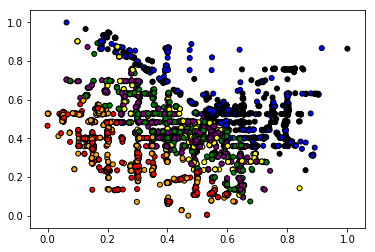

In [6]:
#------------------------------README-----------------------------------------
#For this part the data that is passed to kmeans algorithm 
#has 2 dimensions, 1 for latitude and longitude and 1 for reviews
#the first  dimension is for longitude and langitude and the second 
#dimension is for review.
#Feature axtraction for reviews and normilzing has been done
#using tf-idf. but due to memory problems, I wasn't able to convert the result 
#tf-idf to dense. I have used TruncatedSVD which also accepts a sparse matrix
#to project all the dimensions for reviews into one!
#The same technique, TruncatedSVD has been used to project latitude and
#longitude into one dimesion So eventually the data passed to Kmeans
#algorithm has only 2 dimensions.
#------------------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import json
import sklearn

reviews_file_name = 'yelp_academic_dataset_review.json'
file_name = 'yelp_academic_dataset_business.json'

def create_reviews_data_frame_from_json(file_name):
    data = []
    with open(file_name) as f:
        for line in f:
            data.append(json.loads(line))
    return  pd.DataFrame(data)

reviews_df = create_reviews_data_frame_from_json(reviews_file_name)
merged = reviews_df.merge(df, left_on='business_id', right_on='business_id')


reviewsDict = {}
for index, row in merged.iterrows():
    if row['business_id'] in reviewsDict:
        another_review = " " + row['text']
        reviewsDict[row['business_id']]['reviews'] += another_review
    else:
        row_dict = {}
        row_dict['latitude'] = row['latitude']
        row_dict['longitude'] = row['longitude']
        row_dict['reviews'] = row['text']
        reviewsDict[row['business_id']] = row_dict
        
review_list = []
latitude_list = []
longitude_list = []
latitude_longitude_list = []
for business_id in reviewsDict:
    latitude_longitude_vector = []
    review_list.append(reviewsDict[business_id]['reviews'])
    latitude_list.append(reviewsDict[business_id]['latitude'])
    longitude_list.append(reviewsDict[business_id]['longitude'])
    latitude_longitude_vector.append(reviewsDict[business_id]['latitude'])
    latitude_longitude_vector.append(reviewsDict[business_id]['longitude'])
    latitude_longitude_list.append(latitude_longitude_vector)
    

vectorizer = TfidfVectorizer(stop_words='english')
reviews_vectors =  vectorizer.fit_transform(review_list)

print("done")
 
svd = TruncatedSVD(n_components=1, n_iter=7, random_state=42)
svd1 = TruncatedSVD(n_components=1, n_iter=7, random_state=42)
reviews_vectors = svd.fit_transform(reviews_vectors)
latitude_longitude_list = svd1.fit_transform(latitude_longitude_list)

final_result = []
for i in range(0,len(reviews_vectors)):
    vector = []
    review = reviews_vectors[i][0]
    latitude_longitude = latitude_longitude_list[i][0]
    vector.append(latitude_longitude)
    vector.append(review)
    final_result.append(vector)
    

kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit_predict(final_result)

labels2 = kmeans.labels_
colors =['red','purple', 'blue', 'green','yellow','black', 'orange'] 
plt.scatter(longitude_list, latitude_list, marker='o', c=labels2, s=25, edgecolor='k', cmap=matplotlib.colors.ListedColormap(colors))

 

In [12]:
ri = metrics.adjusted_rand_score(labels2,labels)
print(ri)


0.09544964025571281
